In [67]:
## Import necessary module
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import AffinityPropagation
from sklearn import metrics
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline
from sklearn import tree
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.metrics import classification_report
import statistics as stat
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import plotly.express as px
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import validation_curve
from numpy import mean
from numpy import std

### Data cleaning and preprocessing

In [2]:
#Create list of position for aggregating
offensive = ["RW", "ST", "LW", "CF", "RS", "LS", "RF", "LF"]
middle = ["RCM", "CDM", "RDM", "LCM", "CAM", "LDM", "LM", "RM", "CM", "LAM", "RAM"]
defensive = ["LCB", "RCB", "LB", "RB", "CB", "RWB", "LWB"]
gk = ["GK"]

In [3]:
#List of column to keep
columns_to_keep = ['short_name', 'club_position', 'age','potential','international_reputation', 
                   'pace', 'shooting', 'passing', 'value_eur',
       'dribbling', 'defending', 'physic', 'attacking_crossing',
       'attacking_finishing', 'attacking_heading_accuracy',
       'attacking_short_passing', 'attacking_volleys', 'skill_dribbling',
       'skill_curve', 'skill_fk_accuracy', 'skill_long_passing',
       'skill_ball_control', 'movement_acceleration', 'movement_sprint_speed',
       'movement_agility', 'movement_reactions', 'movement_balance',
       'power_shot_power', 'power_jumping', 'power_stamina', 'power_strength',
       'power_long_shots', 'mentality_aggression', 'mentality_interceptions',
       'mentality_positioning', 'mentality_vision', 'mentality_penalties',
       'mentality_composure', 'defending_marking_awareness',
       'defending_standing_tackle', 'defending_sliding_tackle',
       'goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking',
       'goalkeeping_positioning']

In [4]:
#Read dataset and create position variable
df = pd.read_csv('players_22.csv')
df = df[columns_to_keep]
#df.loc[df['goalkeeping_speed'].isna(),'goalkeeping_speed'] = 0
df.drop(df.columns[df.columns.str.contains('url')],axis=1,inplace=True)
df['position'] = np.nan
df.loc[df['club_position'].isin(middle),'position'] = 'middle'
df.loc[df['club_position'].isin(offensive),'position'] = 'offensive'
df.loc[df['club_position'].isin(defensive),'position'] = 'defensive'
df.loc[df['club_position'].isin(gk),'position'] = 'gk'
df['position'] = np.where(df['position'].isna(),df['club_position'],df['position'])


d:\python\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning: Columns (25,108) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [144]:
k_char = df[['KCluster','pace','shooting','dribbling',
'defending','physic','passing','value_eur']].groupby('KCluster').agg('mean')\
    .round(0).reset_index()

#### Exploratory Data Analysis

In [6]:
#Fill na and drop uncessary observation
df.fillna({'pace':0,'shooting':0,'passing':0,'dribbling':0,'defending':0,'physic':0},inplace=True)
df.dropna(inplace=True)
df=df[~df['position'].isin(['RES','SUB'])]

In [20]:
df.head()

,short_name,club_position,age,potential,international_reputation,pace,shooting,passing,value_eur,dribbling,...,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,position
0,L. Messi,RW,34,93,5,85.0,92.0,91.0,78000000.0,95.0,...,75,96,20,35,24,6,11,15,14,offensive
1,R. Lewandowski,ST,32,92,5,78.0,92.0,79.0,119500000.0,86.0,...,90,88,35,42,19,15,6,12,8,offensive
2,Cristiano Ronaldo,ST,36,91,5,87.0,94.0,80.0,45000000.0,88.0,...,88,95,24,32,24,7,11,15,14,offensive
3,Neymar Jr,LW,29,91,5,91.0,83.0,86.0,129000000.0,94.0,...,93,93,35,32,29,9,9,15,15,offensive
4,K. De Bruyne,RCM,30,91,4,76.0,86.0,93.0,125500000.0,88.0,...,83,89,68,65,53,15,13,5,10,middle


In [96]:
#Number of players in each position
df['position'].value_counts()

defensive    2848
middle       2790
offensive    1367
gk            701
Name: position, dtype: int64

d:\python\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


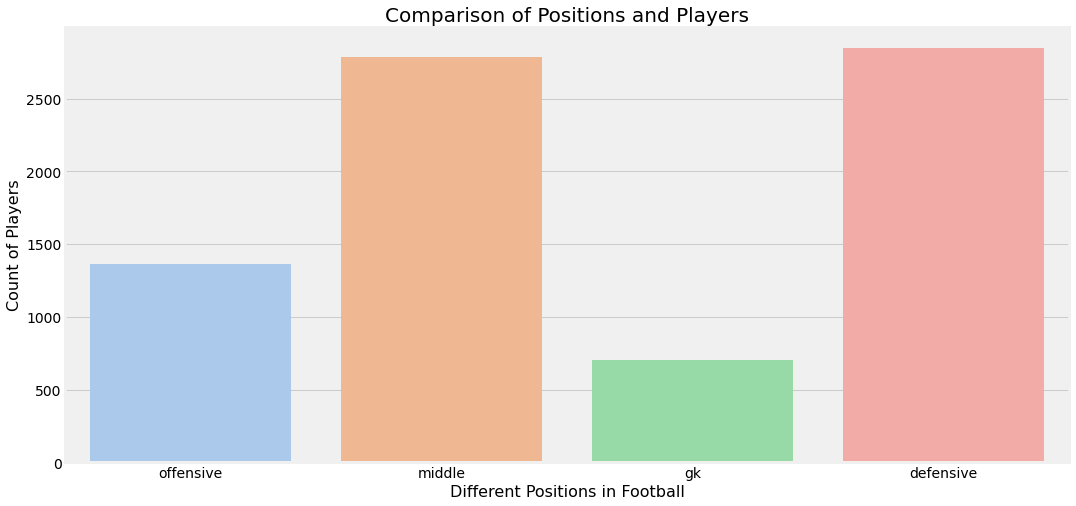

In [10]:
plt.figure(figsize = (18, 8))
plt.style.use('fivethirtyeight')
ax = sns.countplot('position', data = df, palette = 'pastel')
ax.set_xlabel(xlabel = 'Different Positions in Football', fontsize = 16)
ax.set_ylabel(ylabel = 'Count of Players', fontsize = 16)
ax.set_title(label = 'Comparison of Positions and Players', fontsize = 20)
plt.show()

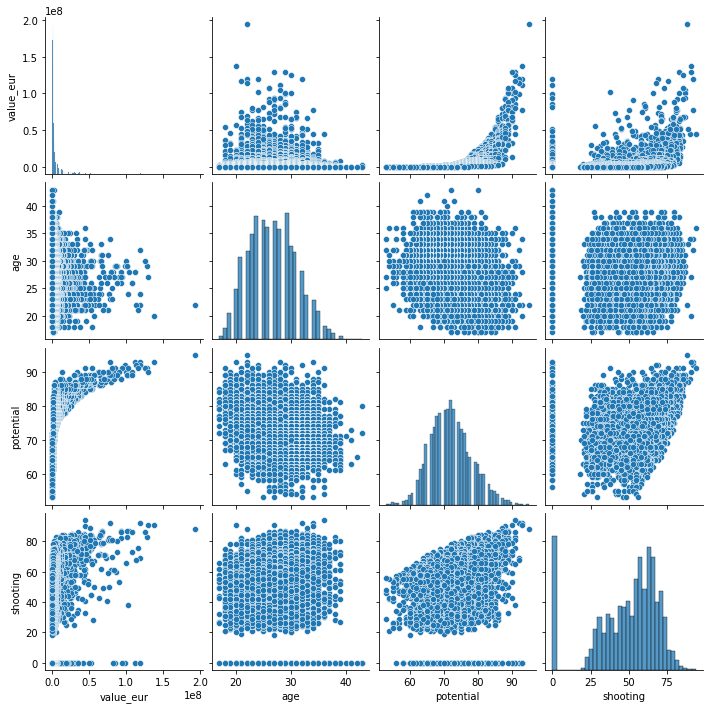

In [9]:
#Correlation and distribution plot between select variables
g = sns.pairplot(df[['value_eur','age','potential','shooting']])

In [8]:
#Count number of missing value
df.isna().sum()

short_name                     0
club_position                  0
age                            0
potential                      0
international_reputation       0
pace                           0
shooting                       0
passing                        0
value_eur                      0
dribbling                      0
defending                      0
physic                         0
attacking_crossing             0
attacking_finishing            0
attacking_heading_accuracy     0
attacking_short_passing        0
attacking_volleys              0
skill_dribbling                0
skill_curve                    0
skill_fk_accuracy              0
skill_long_passing             0
skill_ball_control             0
movement_acceleration          0
movement_sprint_speed          0
movement_agility               0
movement_reactions             0
movement_balance               0
power_shot_power               0
power_jumping                  0
power_stamina                  0
power_stre

#### Train-Test splitting

In [7]:
#Create independent and dependent variable
y = df['position']
#x = df.drop('position',axis=1)
x = df._get_numeric_data()

In [8]:
#Split train-test set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

In [110]:
#Standardization variables for clustering
scale= StandardScaler()
x = scale.fit_transform(x) 

### Decision tree and Random Forest

#### Decision tree

In [122]:
dt_default = DecisionTreeClassifier(random_state=42)
dt_default.fit(x_train, y_train)

DecisionTreeClassifier(random_state=42)

In [123]:
#Train the default model on test set
expected_y = y_test
predicted_y = dt_default.predict(x_test)

In [124]:
#Create classification report of default model on test set
print(metrics.classification_report(expected_y, predicted_y))
print(metrics.confusion_matrix(expected_y, predicted_y))

              precision    recall  f1-score   support

   defensive       0.86      0.83      0.84       695
          gk       1.00      1.00      1.00       170
      middle       0.72      0.73      0.72       715
   offensive       0.69      0.69      0.69       347

    accuracy                           0.78      1927
   macro avg       0.81      0.81      0.81      1927
weighted avg       0.79      0.78      0.78      1927

[[579   0 110   6]
 [  0 170   0   0]
 [ 89   0 522 104]
 [  9   0  98 240]]


In [54]:
#Create hyperparameter for grid search
params = {
    'max_depth': [2, 3, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"]
}

In [56]:
#Grid search for all the best hyperparameter
clf = DecisionTreeClassifier(random_state=42)
grid_search = GridSearchCV(estimator=clf, 
                           param_grid=params, 
                           cv=4, n_jobs=-1, verbose=1, scoring = "accuracy")
%%time
grid_search.fit(x_train, y_train)

In [58]:
#Create list of grid search result and select top 5
score_df = pd.DataFrame(grid_search.cv_results_)
score_df.nlargest(5, "mean_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,0.026480,0.000531,0.003672,0.000699,gini,2,5,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.728028,0.748789,0.734948,0.736842,0.737152,0.007477,41
1,0.025845,0.000501,0.007373,0.005507,gini,2,10,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.728028,0.748789,0.734948,0.736842,0.737152,0.007477,41
2,0.029757,0.006376,0.005136,0.000549,gini,2,20,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.728028,0.748789,0.734948,0.736842,0.737152,0.007477,41
3,0.029140,0.002934,0.004168,0.000991,gini,2,50,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.728028,0.748789,0.734948,0.736842,0.737152,0.007477,41
4,0.026368,0.001256,0.003850,0.000712,gini,2,100,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.728028,0.748789,0.734948,0.736842,0.737152,0.007477,41


In [90]:
#Fit decision tree with the best parameter and predict on test set
dt_best = grid_search.best_estimator_
dt_best.fit(x_train,y_train)
expected_y = y_test
predicted_y = dt_best.predict(x_test)

DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_leaf=20,
                       random_state=42)

In [93]:
#Create classification report
print(metrics.classification_report(expected_y, predicted_y))
print(metrics.confusion_matrix(expected_y, predicted_y))

              precision    recall  f1-score   support

   defensive       0.87      0.89      0.88       695
          gk       1.00      1.00      1.00       170
      middle       0.74      0.75      0.74       715
   offensive       0.71      0.65      0.68       347

    accuracy                           0.80      1927
   macro avg       0.83      0.82      0.82      1927
weighted avg       0.80      0.80      0.80      1927

[[617   0  76   2]
 [  0 170   0   0]
 [ 88   0 537  90]
 [  8   0 114 225]]


In [95]:
#Export classification report in markdown for converting to LaTex
report = classification_report(expected_y, predicted_y, output_dict=True)
acc_rep = pd.DataFrame(report).transpose().round(2)
acc_rep.to_markdown('accuracy_report.md')

#### Random forest

In [75]:
#Initizalize random forest and grid search for hyperparameter tuning
rfc = RandomForestClassifier()
n_estimators = [100, 300, 500, 800, 1200]
max_depth = [5, 8, 15, 25, 30]
min_samples_split = [2, 5, 10, 15, 100]
min_samples_leaf = [1, 2, 5, 10] 

hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf)

gridF = GridSearchCV(rfc, hyperF, cv = 3, verbose = 1, 
                      n_jobs = -1)

Fitting 3 folds for each of 500 candidates, totalling 1500 fits


In [76]:
#Create the dataframe of combination of hyperparameter and select the best five
score_df = pd.DataFrame(gridF.cv_results_)
score_df.nlargest(5, "mean_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
311,5.229019,0.054307,0.254986,0.061688,25,1,10,300,"{'max_depth': 25, 'min_samples_leaf': 1, 'min_...",0.859886,0.851506,0.862409,0.857934,0.004660,1
327,8.141288,1.045193,0.318298,0.003656,25,2,2,500,"{'max_depth': 25, 'min_samples_leaf': 2, 'min_...",0.858848,0.854102,0.859813,0.857588,0.002496,2
302,7.052934,0.269121,0.292663,0.007967,25,1,2,500,"{'max_depth': 25, 'min_samples_leaf': 1, 'min_...",0.860924,0.854102,0.856698,0.857241,0.002811,3
333,14.126159,0.700689,0.566779,0.055010,25,2,5,800,"{'max_depth': 25, 'min_samples_leaf': 2, 'min_...",0.859367,0.853063,0.858255,0.856895,0.002747,4
404,19.658531,4.536987,0.888816,0.208411,30,1,2,1200,"{'max_depth': 30, 'min_samples_leaf': 1, 'min_...",0.858848,0.852025,0.859294,0.856722,0.003326,5


In [84]:
#Fit the model with best parameter and predict on test set
rfc_best = gridF.best_estimator_
rfc_best.fit(x_train,y_train)
expected_y = y_test
predicted_y = rfc_best.predict(x_test)

RandomForestClassifier(max_depth=25, min_samples_split=10, n_estimators=300)

In [86]:
#Print classification report on test set
print(metrics.classification_report(expected_y, predicted_y))
print(metrics.confusion_matrix(expected_y, predicted_y))

              precision    recall  f1-score   support

   defensive       0.89      0.93      0.91       695
          gk       1.00      1.00      1.00       170
      middle       0.80      0.81      0.81       715
   offensive       0.79      0.71      0.75       347

    accuracy                           0.85      1927
   macro avg       0.87      0.86      0.87      1927
weighted avg       0.85      0.85      0.85      1927

[[646   0  48   1]
 [  0 170   0   0]
 [ 71   0 581  63]
 [  5   0  94 248]]


In [89]:
#Export classification report to markdown to convert to LaTex
report = classification_report(expected_y, predicted_y, output_dict=True)
acc_rep = pd.DataFrame(report).transpose().round(2)
acc_rep.to_markdown('accuracy_report_random_forest.md')

### Linear Discriminant Analysis

In [134]:
#Initialize LDA model
model = LinearDiscriminantAnalysis()

In [135]:
#Train model
model.fit(x_test,y_test)

LinearDiscriminantAnalysis()

In [136]:
#Fit model on test set
expected_y = y_test
predicted_y = model.predict(x_test)

In [137]:
#Print classification matrix on test set
print(metrics.classification_report(expected_y, predicted_y))
print(metrics.confusion_matrix(expected_y, predicted_y))

              precision    recall  f1-score   support

   defensive       0.91      0.88      0.90       695
          gk       1.00      1.00      1.00       170
      middle       0.78      0.81      0.79       715
   offensive       0.76      0.77      0.76       347

    accuracy                           0.84      1927
   macro avg       0.86      0.86      0.86      1927
weighted avg       0.84      0.84      0.84      1927

[[613   0  80   2]
 [  0 170   0   0]
 [ 56   0 576  83]
 [  2   0  79 266]]


In [138]:
#Export classification matrix to markdown to convert to LaTex
report = classification_report(expected_y, predicted_y, output_dict=True)
acc_rep = pd.DataFrame(report).transpose().round(2)
acc_rep.to_markdown('accuracy_report_da.md')

### K-means clustering

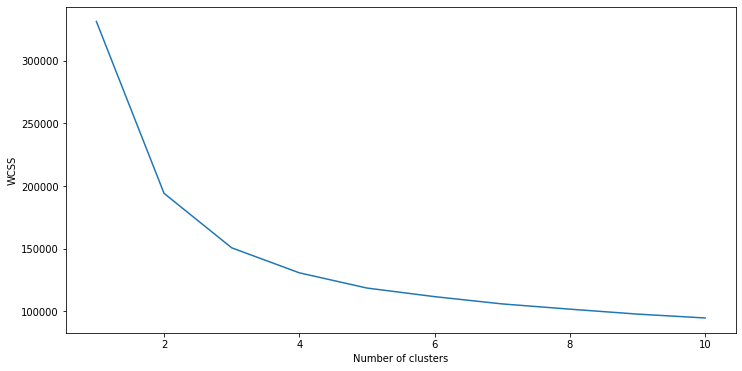

In [111]:
#Create elbow graph
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(x)
    wcss.append(kmeans.inertia_)
plt.figure(figsize=(12,6))
plt.plot(range(1, 11), wcss)
#plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.savefig('Elbow.png')
plt.show()


In [112]:
#K-mean cluster and merge the cluster to the original data frame
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(x)
df['KCluster']=pred_y.tolist()

In [113]:
#List of selected variable for radar chart
graph_var = ['pace','shooting','dribbling','defending','physic','passing','goalkeeping_positioning']

In [114]:
#Create radar chart of selected variable
polar=df.groupby("KCluster").mean().reset_index()
polar=pd.melt(polar,id_vars=["KCluster"])
polar=polar[polar['variable'].isin(graph_var)]
fig4 = px.line_polar(polar, r="value", theta="variable", color="KCluster", line_close=True,height=500,width=700)
fig4.show()

In [115]:
#Export summary statistics of selected variables by k-means cluster
k_char = df[['KCluster','pace','shooting','dribbling','defending','physic','passing','value_eur']].groupby('KCluster').agg('mean').round(0).reset_index()
k_count = pd.DataFrame(df['KCluster'].value_counts()).reset_index()
k_count.columns = ['KCluster','Number of Player']
k_char = k_char.merge(k_count,on='KCluster',how='left')
k_char = k_char.astype('int')
k_char.columns = ['KCluster', 'Pace', 'Shooting', 'Dribbling', 'Defending', 'Physic',
       'Passing', 'Value (Eur)', 'Number of Player']
k_char['Value (Eur)'] = k_char['Value (Eur)'].astype('int').apply(lambda x : "{:,}".format(x))
k_char.to_markdown('KChar.md',index=False)

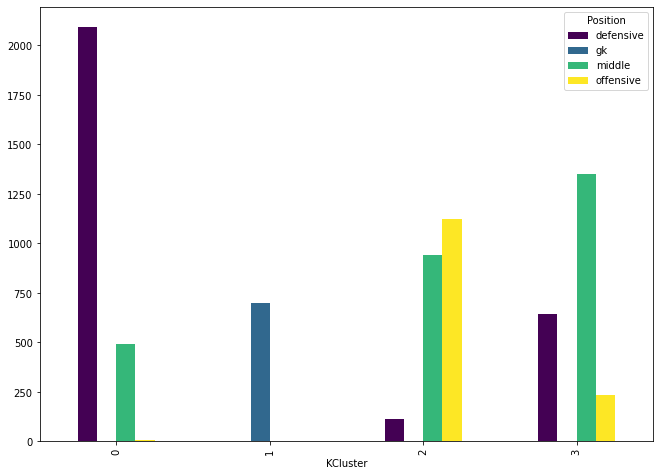

In [18]:
#Create graph of number of positions in each cluster
pos_by_k = df[['position','KCluster','APCluster']].groupby(['KCluster','position']).agg('count').reset_index()
pos_by_k.columns = ['KCluster','Position','Number of Players']
pos_by_k.to_markdown('pos_k.md',index=False)
plot_by_k = pos_by_k.pivot('KCluster','Position','Number of Players').fillna(0)
plot_by_k.plot(kind='bar',
        stacked=False,
        title='',
               figsize = (11,8),colormap='viridis')
plt.savefig('K_Num.png')

### Afinity Propagation Clustering

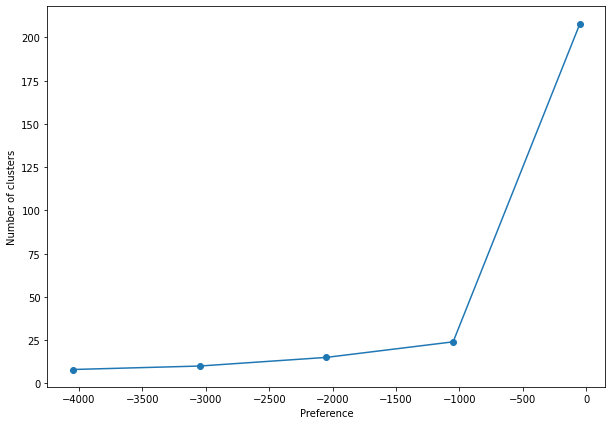

In [191]:
#Run search for the best preference parameter
preferences = np.arange(-50,-4600,-1000)
clusters = []

for p in preferences:
    af = AffinityPropagation(preference=p, damping=0.6, max_iter=400, verbose=False).fit(x)
    labels_af = pd.DataFrame(af.labels_)
    clusters.append(len(af.cluster_centers_indices_))

plt.figure(figsize=(10,7))
plt.xlabel("Preference")
plt.ylabel("Number of clusters")
plt.plot(preferences,clusters, marker='o')

In [9]:
#Create clusters based on selected parameter and append new cluster to observations in original dataframe
af = AffinityPropagation(preference=-4400, damping=0.6,
                         max_iter=400, verbose=False).fit(x)
labels_af = pd.DataFrame(af.labels_)
print(len(af.cluster_centers_indices_)) #Number of cluster
df['APCluster'] = af.labels_.tolist()

7

In [227]:
#Create list of select variables to include in radar chart
graph_var = ['pace','shooting','dribbling','defending','physic','passing']

In [19]:
#Create radar chart for selected variables on each cluster
polar=df.groupby("APCluster").mean().reset_index()
polar=pd.melt(polar,id_vars=["APCluster"])
polar=polar[polar['variable'].isin(graph_var)]
fig4 = px.line_polar(polar, r="value", theta="variable", color="APCluster", line_close=True,height=500,width=700)
fig4.show()

In [20]:
#Create summary statistics of selected variables
ap_char = df[['APCluster','pace','shooting','dribbling','defending','physic','passing','value_eur']].groupby('APCluster').agg('mean').round(0).reset_index()
ap_count = pd.DataFrame(df['APCluster'].value_counts()).reset_index()
ap_count.columns = ['APCluster','Number of Player']
ap_char = ap_char.merge(ap_count,on='APCluster',how='left')
ap_char = ap_char.astype('int')
ap_char.columns = ['APCluster', 'Pace', 'Shooting', 'Dribbling', 'Defending', 'Physic',
       'Passing', 'Value (Eur)', 'Number of Player']
ap_char['Value (Eur)'] = ap_char['Value (Eur)'].astype('int').apply(lambda x : "{:,}".format(x))
ap_char.to_markdown('APChar.md',index=False)

In [ ]:
#Create graph of number of position in each cluster
pos_by_ap = df[['position','KCluster','APCluster']].groupby(['APCluster','position']).agg('count').reset_index()
pos_by_ap.columns = ['APCluster','Position','Number of Players']
pos_by_ap.to_markdown('pos_ap.md',index=False)
plot_by_ap = pos_by_ap.pivot('APCluster','Position','Number of Players').fillna(0)
plot_by_ap.plot(kind='bar',
        stacked=False,
        title='',
               figsize = (11,8),colormap='viridis')
plt.savefig('AP_Num.png')